## Libraries

In [1]:
import re
import os 
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE, Isomap
import torch 
import torch.nn as nn
from torch.nn import Linear, Dropout, MSELoss
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from transformers import AlbertModel, AlbertConfig, AlbertTokenizer

plt.style.use('seaborn')
#warnings.filterwarnings('ignore')

## Global arguments

In [2]:
TRANS_SPEC = 'albert-large-v2'
OUTPUT_TYPE = 'cls'
MODEL_TYPE = 'ff'
DROPOUT_RATE = 0.1
DIM_HIDDEN_1 = 150
DIM_HIDDEN_2 = 150
SEQ_LEN = 220
LR = 2e-5 
NUM_EPOCHS = 4
BATCH_SIZE = 16

GPU = torch.device("cuda:0")

STAMP = f'{TRANS_SPEC}-{OUTPUT_TYPE}-{MODEL_TYPE}-{DIM_HIDDEN_1}-{DIM_HIDDEN_2}-{DROPOUT_RATE}_le_{SEQ_LEN}_lr_{LR}_ep_{NUM_EPOCHS}_ba_{BATCH_SIZE}'

## Load and split data

In [3]:
TEXT_COLS = ['name', 'description', 'space', 'house_rules', 'access', 'interaction', 'neighborhood_overview', 'notes', 'transit']
INPUT_COLS = ['name', 'description']

df_train = pd.read_csv('./input/df_pre_train_deep.csv')
df_test = pd.read_csv('./input/df_pre_test_deep.csv')

In [4]:
df_train, df_val = train_test_split(
    df_train,
    test_size = 0.20,
    shuffle = True,
    random_state = 2020
)

df_train = df_train.reset_index(drop = True)
df_val = df_val.reset_index(drop = True)
df_test = df_test.reset_index(drop = True)

print(f'Train: {df_train.shape}')
print(f'Val: {df_val.shape}')
print(f'Test: {df_test.shape}')

Train: (8320, 81)
Val: (2080, 81)
Test: (2600, 81)


## Preprocess sequences

In [5]:
def clean_string(string):
    '''Removes unnecessary characters from string'''
    if pd.isna(string):
        return ''
    string = str(string)
    string = re.sub("&", " and ", string)
    string = re.sub("-", " ", string)
    string = re.sub("\.\.\.", ".", string)
    string = re.sub("\.\.", ".", string)
    string = re.sub(r"\\", " ", string)
    string = re.sub("/", " ", string)
    string = re.sub("what's", "what is", string)
    string = re.sub("it\'s", "it is", string)
    string = re.sub("\'ve", " have", string)
    string = re.sub("can\'t", "cannot", string)
    string = re.sub("n\'t", " not", string)
    string = re.sub("i\'m", "i am", string)
    string = re.sub("\'re", " are", string)
    string = re.sub("\'d", " would", string)
    string = re.sub("\'ll", " will", string)
    string = re.sub("he\'s", "he is", string)
    string = re.sub("she\'s", "she is", string)
    string = re.sub("that\'s", "that is", string)
    string = re.sub("what\'s", "what is", string)
    string = re.sub("where\'s", "where is", string)
    string = re.sub("how\'s", "how is", string)
    string = re.sub("who\'s", "who is", string)
    string = re.sub("won\'t", "will not", string)
    string = re.sub("n\'t", " not", string)
    string = re.sub("n\'", "ng", string)
    string = re.sub("\'bout", "about", string)
    string = re.sub("\'til", "until", string)
    string = re.sub("[^\dA-Za-z\s.,]", " ", string)
    return string

def tokenize_string(first, second, max_len = 512):
    '''Tokenizes a string to ids, masks and token type ids (segment ids)'''
    encoded = tokenizer.encode_plus(
        text = first,
        text_pair = second,
        max_length = max_len,
        add_special_tokens = True,
        pad_to_max_length = True,
    )
    ids =  encoded['input_ids']
    masks = encoded['attention_mask']
    segments = encoded['token_type_ids']
    # Return 3 x (1, d_model) vectors
    return [ids, masks, segments]

def process_df(df, max_len = 512):
    '''Preprocess a whole dataframe ready for a transformer'''
    ids_all, masks_all, segms_all = [], [], []
    for i, row in df.iterrows():
        title = clean_string(row[INPUT_COLS[0]])
        other_cols = '.'.join([clean_string(row[col]) for col in INPUT_COLS[1:]])
        ids, masks, segments = tokenize_string(
            first = title,
            second = other_cols,
            max_len = max_len
        )
        ids_all.append(ids)
        masks_all.append(masks)
        segms_all.append(segments)
    # Return 3 x (N, d_model) matrices
    return [np.asarray(ids_all, dtype = np.int32), 
            np.asarray(masks_all, dtype = np.int32), 
            np.asarray(segms_all, dtype = np.int32)]

In [6]:
#tokenizer = AlbertTokenizer.from_pretrained(TRANS_SPEC)
tokenizer = AlbertTokenizer.from_pretrained('./input/tokenizer_albert-large-v2-cls-ff-150-150-0.1_le_220_lr_1e-05_ep_7_ba_8-mse-0.3327')

x_train = process_df(df_train, max_len = SEQ_LEN)
x_val = process_df(df_val, max_len = SEQ_LEN)
x_test = process_df(df_test, max_len = SEQ_LEN)

y_train = df_train['log_price']
y_val = df_val['log_price']
y_test = df_test['log_price']

## Display data

In [7]:
example = df_train.loc[101, INPUT_COLS]
title = example[0]
others = '. '.join([str(example[col]) for col in INPUT_COLS[1:]])
tokenized = tokenize_string(title, others, max_len = SEQ_LEN)

print('--------- Description as original --------- \n')
print(clean_string(title), '\n\n', clean_string(others), '\n')

print('--------- Description as tokens --------- \n')
print(tokenizer.tokenize(clean_string(title + others), max_len = SEQ_LEN), '\n')

print('--------- Description as numeric inputs --------- \n')
print(tokenized[0], '\n')
print(tokenized[1], '\n')
print(tokenized[2], '\n')

--------- Description as original --------- 

Apartment with Balconies in La Latina C Aguas 

 Dream apartment totally new. Full of details, color and life. It has a magnificent photogenic room where spending the afternoons and evenings with friends and family is a pleasure. A dining room where the shared meals are joys. A large kitchen where nothing is missing. Two rooms with lots of light and closets where you can rest will be like being at home. And two full bathrooms, in which short showers do not exist. The building is in rehabilitation so there may be noise. We find a large living room. With a comfortable sofa bed to relax after a day of walking. Two balconies overlooking the main street, through which a lot of light enters that fills the house with life. An open kitchen where you will find all the necessary implements. A room with a double bed of 140, and the second room with 2 single beds, both rooms with their wardrobes, and two great bathrooms which will cost you to leave in 

## Data loaders

In [8]:
class AirbnbDataset(Dataset):    
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        return len(self.inputs[0])
    
    def __getitem__(self, index):
        x_1, x_2, x_3 = self.inputs[0][index], self.inputs[1][index], self.inputs[2][index] 
        if self.targets is not None:
            y = self.targets[index]
            return (x_1, x_2, x_3), y # int32 & float64
        else:
            return (x_1, x_2, x_3)

In [9]:
dataset_train = AirbnbDataset(x_train, y_train)
dataset_val = AirbnbDataset(x_val, y_val)
dataset_test = AirbnbDataset(x_test, y_test)

train_gen = DataLoader(dataset_train, batch_size = BATCH_SIZE, shuffle = True)
val_gen = DataLoader(dataset_val, batch_size = BATCH_SIZE, shuffle = True)
test_gen = DataLoader(dataset_test, batch_size = 1, shuffle = False)

## Specify model

In [10]:
class TransFFModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.albert_model = AlbertModel.from_pretrained(TRANS_SPEC)    
        self.albert_model.config.max_position_embeddings = SEQ_LEN
        self.d_model = self.albert_model.config.hidden_size
        self.drop1 = Dropout(DROPOUT_RATE)
        self.drop2 = Dropout(DROPOUT_RATE)
        self.lin1 = Linear(self.d_model, DIM_HIDDEN_1)
        self.lin2 = Linear(DIM_HIDDEN_1, 1)
        
    def forward(self, ids, masks, segms):
        h_albert = self.albert_model(ids, attention_mask = masks, token_type_ids = segms)[0][:, 0, :].view(-1, self.d_model) # float32
        h = self.drop1(h_albert)
        h = self.lin1(h)
        h = self.drop2(h)
        y = self.lin2(h).view(-1)
        return y

In [11]:
model = TransFFModel().to(GPU)

model.load_state_dict(torch.load('./input/model_albert-large-v2-cls-ff-150-150-0.1_le_220_lr_1e-05_ep_7_ba_8-mse-0.3327.pt'))

loss_function = MSELoss() 

optimizer = Adam(model.parameters(), lr = LR)

## Input embedding visualization

In [29]:
freq_dict = {}

# get frequencies
for i_row in np.arange(x_train[0].shape[0]):
    for i_col in np.arange(x_train[0].shape[1]):
        token_id = x_train[0][i_row, i_col]
        token_string = tokenizer.sp_model.id_to_piece(int(token_id))
        if token_string in freq_dict:
            freq_dict[token_string] += 1
        else:
            freq_dict[token_string] = 1

# sort
freq_dict = {key: val for key, val in sorted(freq_dict.items(), key = lambda item: item[1], reverse = True)}

# print top 40
i = 0
for word, freq in freq_dict.items(): 
    if i < 40:
        print(f"{word}\t\t{freq}")
        i += 1

<pad>		306024
,		73083
▁the		63925
.		62599
▁and		49684
▁a		40985
▁in		28133
▁to		26103
s		25442
▁is		25400
▁		25302
▁of		24941
▁with		21778
[SEP]		16640
▁you		16047
▁apartment		14801
▁for		11773
▁room		10751
▁from		9215
[CLS]		8320
▁it		7807
▁kitchen		7264
▁are		6793
▁bedroom		6792
▁bed		6772
▁on		6427
▁will		6239
▁2		5923
▁can		5843
▁bathroom		5837
▁located		5595
▁has		5369
▁all		5369
▁flat		5355
▁very		5205
▁living		4909
▁your		4766
▁this		4664
▁by		4648
▁or		4615
▁minutes		4476


In [34]:
# copy dict keys
price_dict = dict.fromkeys(freq_dict, 0)

# get sum of prices
for i_row in np.arange(x_train[0].shape[0]):
    for i_col in np.arange(x_train[0].shape[1]):
        token_id = x_train[0][i_row, i_col]
        token_string = tokenizer.sp_model.id_to_piece(int(token_id))
        obs_price = y_train[i_row]
        if token_string in price_dict:
            price_dict[token_string] += obs_price

# compute average with frequencies
for token in price_dict.keys():
    price_dict[token] /= freq_dict[token]

# drop with < 30 frequency and sort 
price_dict = {key: val for key, val in price_dict.items() if freq_dict[key] > 30}
price_dict = {key: val for key, val in sorted(price_dict.items(), key = lambda item: item[1], reverse = True)}

# print top and bottom 20
i = 0
for word, price in price_dict.items(): 
    if i < 20 or i > (len(price_dict) - 20):
        print(f"{word}\t\t{price}")
    i += 1

▁wanda		6.0206679938430865
▁champions		5.896895032088689
▁metropolitan		5.825031817996916
▁league		5.824973247831942
▁final		5.554066896948633
▁marylebone		5.339380982819392
phe		5.198200313152707
▁versailles		5.184511533810359
▁arc		5.140311055978394
▁har		5.074677451705582
▁trio		5.066979196763095
▁kensington		5.027838788697076
▁artwork		5.020725717835398
▁sleek		4.999905487275775
▁serra		4.978684528377758
▁pomp		4.977704744404474
▁hyde		4.969039292780806
▁outstanding		4.968221471276226
▁exquisite		4.96074764937302
▁featuring		4.957684247965553
▁kos		3.736579235848804
oki		3.7203830060553593
▁lamp		3.7113961741599635
▁shared		3.710119425778808
▁cats		3.6993901864718826
▁fix		3.695976134900156
▁students		3.6759826524871775
▁guys		3.6608313960852437
sion		3.6537842378796936
mate		3.6407974697345953
iki		3.596341529289631
▁female		3.592862453463999
arche		3.5780391196958643
archi		3.5546963911610074
▁roommate		3.5409492243821945
mates		3.4704186986874226
share		3.418192696572579
pati		3

In [44]:
priciest_top100 = {key: price_dict[key] for key in list(price_dict.keys())[:100]}
cheapest_top100 = {key: price_dict[key] for key in list(price_dict.keys())[-100:]}

embed_matrix = model.albert_model.get_input_embeddings()

tokens = list(priciest_top100.keys())
tokens.extend(list(cheapest_top100.keys()))

# get embeddings (E = 128)
with torch.no_grad():
    ids = np.array([np.full(SEQ_LEN, tokenizer.sp_model.piece_to_id(token)) for token in tokens])
    ids = torch.Tensor(ids).to(GPU, dtype = torch.int64)
    embeds = embed_matrix(ids)
    embeds = torch.mean(embeds, dim = 1)
    embeds = embeds.cpu().numpy()

In [56]:
tsne_model = TSNE(n_components = 2)

z = tsne_model.fit_transform(embeds)

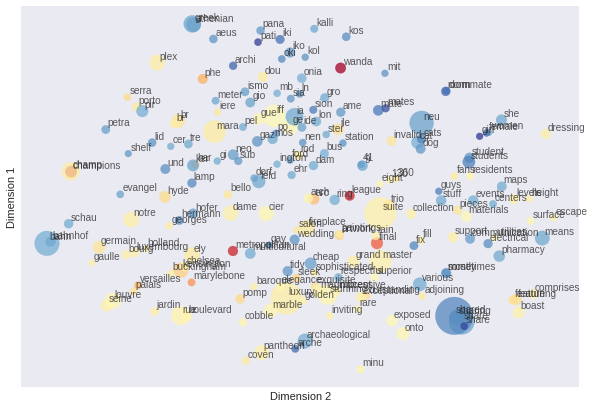

In [58]:
prices = [price_dict[token] for token in tokens]
freqs = np.array([freq_dict[token] for token in tokens])

fig = plt.figure(figsize = (10, 7))
plt.scatter(z[:, 0], z[:, 1], alpha = 0.75, c = prices, s = freqs*1.5, cmap = 'RdYlBu_r')
for i, annot in enumerate(tokens):
    plt.annotate(annot.replace('▁', ''), (z[:, 0][i]+.1, z[:, 1][i]+.3), alpha = 0.75)
plt.yticks([])
plt.xticks([])
plt.ylabel('Dimension 1')
plt.xlabel('Dimension 2')
plt.savefig('./output/tsne_price.pdf', bbox_inches = 'tight');

In [59]:
# tokens with < 30 but no stop words
freq_dict = {key: val for key, val in freq_dict.items() if 30 < val < 7800 }

frequent_top100 = {key: freq_dict[key] for key in list(freq_dict.keys())[:100]}
rarest_top100 = {key: freq_dict[key] for key in list(freq_dict.keys())[-100:]}

embed_matrix = model.albert_model.get_input_embeddings()

tokens = list(frequent_top100.keys())
tokens.extend(list(rarest_top100.keys()))

with torch.no_grad():
    ids = np.array([np.full(SEQ_LEN, tokenizer.sp_model.piece_to_id(token)) for token in tokens])
    #ids = np.array([[tokenizer.sp_model.piece_to_id(token)]*220 for token in tokens])
    ids = torch.Tensor(ids).to(GPU, dtype = torch.int64)
    embeds = embed_matrix(ids)
    embeds = torch.mean(embeds, dim = 1)
    embeds = embeds.cpu().numpy()

In [73]:
tsne_model = TSNE(n_components = 2)

z = tsne_model.fit_transform(embeds)

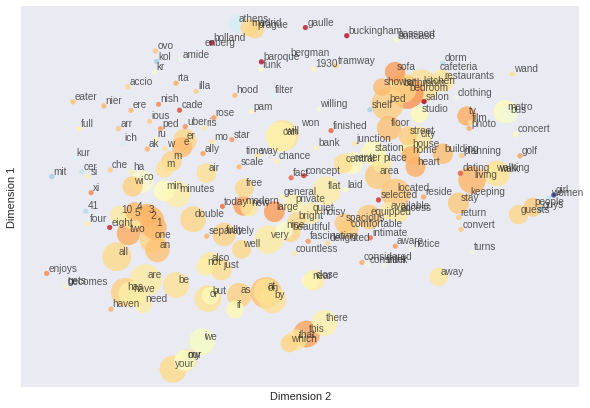

In [80]:
prices = [price_dict[token] for token in tokens]
freqs = np.array([freq_dict[token] for token in tokens])
freqs = [f*0.15 if f > 1_000 else 0.75*f for f in freqs]

fig = plt.figure(figsize = (10, 7))
plt.scatter(z[:, 0], z[:, 1], alpha = 0.8, c = prices, s = freqs, cmap = 'RdYlBu_r')
for i, annot in enumerate(tokens):
    plt.annotate(annot.replace('▁', ''), (z[:, 0][i]+.1, z[:, 1][i]+.3), alpha = 0.75)
plt.yticks([])
plt.xticks([])
plt.ylabel('Dimension 1')
plt.xlabel('Dimension 2')
plt.savefig('./output/tsne_freq.pdf', bbox_inches = 'tight');

## Fit model

In [12]:
losses_train = []
losses_val = []
batch_up_freq = int((len(train_gen) // 3))

print(STAMP, '\n')
print(f'----- x_train: {len(x_train[0])} | x_val: {len(x_val[0])} -----')
for i_e in range(NUM_EPOCHS):
    model.train()
    losses_train_e = []
    losses_val_e = []
    # ------------- Training -------------
    for i_b, ((x_1, x_2, x_3), y) in enumerate(train_gen):
        ids = x_1.to(GPU, dtype = torch.int64)
        masks = x_2.to(GPU, dtype = torch.int64)
        segms = x_3.to(GPU, dtype = torch.int64)
        targets = y.to(GPU, dtype = torch.float32)
        optimizer.zero_grad()      
        preds = model(ids, masks, segms) 
        loss = loss_function(preds, targets) # float32 & float32
        losses_train_e.append(loss.detach().cpu().numpy())
        losses_train.append(loss.detach().cpu().numpy()) 
        loss.backward() 
        optimizer.step() 
        # ------------- Batch updates -------------
        if i_b % batch_up_freq == 0:
            print(f'> > > Batch {(i_b+1):03d}/{len(train_gen)} | train loss: {np.mean(losses_train_e[-batch_up_freq:]):.3f}')    
    # ------------- Validation -------------
    model.eval()
    with torch.no_grad():
        for _, ((x_1, x_2, x_3), y) in enumerate(val_gen):
            ids = x_1.to(GPU, dtype = torch.int64)
            masks = x_2.to(GPU, dtype = torch.int64)
            segms = x_3.to(GPU, dtype = torch.int64)
            targets = y.to(GPU, dtype = torch.float32)
            preds = model(ids, masks, segms)
            loss = loss_function(preds, targets)
            losses_val_e.append(loss.detach().cpu().numpy()) 
    losses_val.append(np.mean(losses_val_e))
    print(f'------- Epoch {(i_e+1):02d}/{NUM_EPOCHS:02d} | train loss: {np.mean(losses_train_e):.3f} | valid loss: {np.mean(losses_val_e):.3f}')

albert-base-v2-cls-ff-150-150-0.1_le_220_lr_2e-05_ep_4_ba_16 

----- x_train: 8320 | x_val: 2080 -----
> > > Batch 001/520 | train loss: 15.932
> > > Batch 174/520 | train loss: 0.709
> > > Batch 347/520 | train loss: 0.488
> > > Batch 520/520 | train loss: 0.466
------- Epoch 01/04 | train loss: 0.584 | valid loss: 0.339
> > > Batch 001/520 | train loss: 0.286
> > > Batch 174/520 | train loss: 0.385
> > > Batch 347/520 | train loss: 0.381
> > > Batch 520/520 | train loss: 0.444
------- Epoch 02/04 | train loss: 0.403 | valid loss: 0.346
> > > Batch 001/520 | train loss: 0.928
> > > Batch 174/520 | train loss: 0.397
> > > Batch 347/520 | train loss: 0.332
> > > Batch 520/520 | train loss: 0.356
------- Epoch 03/04 | train loss: 0.363 | valid loss: 0.408
> > > Batch 001/520 | train loss: 0.267
> > > Batch 174/520 | train loss: 0.304
> > > Batch 347/520 | train loss: 0.284
> > > Batch 520/520 | train loss: 0.315
------- Epoch 04/04 | train loss: 0.301 | valid loss: 0.315


## Model evaluation

### Train

In [14]:
losses = []

model.eval()
with torch.no_grad():
    for _, ((x_1, x_2, x_3), y) in enumerate(train_gen):
        ids = x_1.to(GPU, dtype = torch.int64)
        masks = x_2.to(GPU, dtype = torch.int64)
        segms = x_3.to(GPU, dtype = torch.int64)
        targets = y.to(GPU, dtype = torch.float32)
        preds = model(ids, masks, segms)
        loss = loss_function(preds, targets)
        losses.append(loss.item())

np.round_(np.mean(losses), 4)

0.2056

### Test

In [13]:
y_pred = []

model.eval()
with torch.no_grad():
    for _, ((x_1, x_2, x_3), _) in enumerate(test_gen):
        ids = x_1.to(GPU, dtype = torch.int64)
        masks = x_2.to(GPU, dtype = torch.int64)
        segms = x_3.to(GPU, dtype = torch.int64)
        preds = model(ids, masks, segms)
        y_pred.extend(preds.detach().cpu().numpy())

MSE = np.round_(mean_squared_error(y_test, y_pred), 4)
MSE

0.35

## Sentence embedding visualization

In [90]:
cls_embeds = []
y_true = []

model.eval()
with torch.no_grad():
    for _, ((x_1, x_2, x_3), y) in enumerate(train_gen):
        ids = x_1.to(GPU, dtype = torch.int64)
        masks = x_2.to(GPU, dtype = torch.int64)
        segms = x_3.to(GPU, dtype = torch.int64)
        out = model.albert_model(ids, masks, segms)[0][:, 0, :].view(-1, 1024)
        cls_embeds.extend(out.cpu().numpy())
        y_true.extend(y.cpu().numpy())

cls_embeds = np.array(cls_embeds)

In [95]:
tsne_model = TSNE(n_components = 2)

z = tsne_model.fit_transform(cls_embeds)

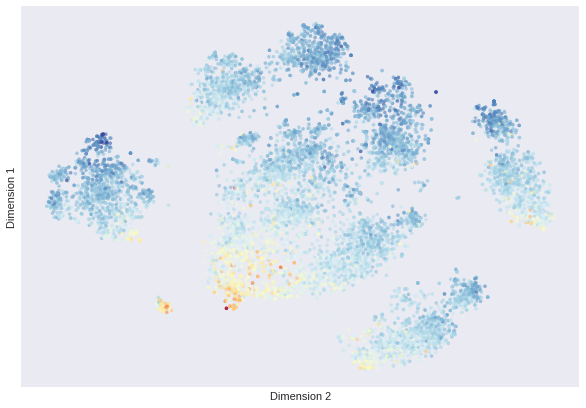

In [119]:
fig = plt.figure(figsize = (10, 7))
plt.scatter(z[:, 0], z[:, 1], alpha = 0.6, s = 10 , c = colors, cmap = 'RdYlBu_r')
plt.yticks([])
plt.xticks([])
plt.ylabel('Dimension 1')
plt.xlabel('Dimension 2')
plt.savefig('./output/tsne_cls.pdf', bbox_inches = 'tight');

## Save training logs

In [18]:
pd.DataFrame(losses_train).to_csv(f'./output/log_train_{STAMP}-mse-{MSE}.csv', index = False)
pd.DataFrame(losses_val).to_csv(f'./output/log_val_{STAMP}-mse-{MSE}.csv', index = False)

## Save model and tokenizer

In [16]:
os.mkdir(f'./input/tokenizer_{STAMP}-mse-{MSE}')
tokenizer.save_pretrained(f'./input/tokenizer_{STAMP}-mse-{MSE}')

torch.save(model.state_dict(), f'./input/model_{STAMP}-mse-{MSE}.pt')

## Prediction for main model

In [25]:
df_train = pd.read_csv('./input/df_pre_train.csv')
df_test = pd.read_csv('./input/df_pre_test.csv')

input_train = process_df(df_train, max_len = SEQ_LEN)
input_test = process_df(df_test, max_len = SEQ_LEN)

dataset_train = AirbnbDataset(input_train, None)
dataset_test = AirbnbDataset(input_test, None)

train_gen = DataLoader(dataset_train, batch_size = BATCH_SIZE, shuffle = False)
test_gen = DataLoader(dataset_test, batch_size = BATCH_SIZE, shuffle = False)

print(f'Train: {input_train[0].shape}')
print(f'Test: {input_test[0].shape}')

Train: (50394, 220)
Test: (12599, 220)


In [33]:
y_pred = []

model.eval()
with torch.no_grad():
    for _, (x_1, x_2, x_3) in enumerate(train_gen):
        ids = x_1.to(GPU, dtype = torch.int64)
        masks = x_2.to(GPU, dtype = torch.int64)
        segms = x_3.to(GPU, dtype = torch.int64)
        preds = model(ids, masks, segms)
        y_pred.extend(preds.detach().cpu().numpy())
        
df_train['text_feature'] = y_pred

In [49]:
y_pred = []

model.eval()
with torch.no_grad():
    for _, (x_1, x_2, x_3) in enumerate(test_gen):
        ids = x_1.to(GPU, dtype = torch.int64)
        masks = x_2.to(GPU, dtype = torch.int64)
        segms = x_3.to(GPU, dtype = torch.int64)
        preds = model(ids, masks, segms)
        y_pred.extend(preds.detach().cpu().numpy())
        
df_test['text_feature'] = y_pred

In [52]:
df_train = df_train.drop(TEXT_COLS, axis = 1)
df_test = df_test.drop(TEXT_COLS, axis = 1)

df_train.to_csv(f'./input/df_final_train_{STAMP}-mse-{MSE}.csv', index = False)
df_test.to_csv(f'./input/df_final_test_{STAMP}-mse-{MSE}.csv', index = False)